# Pipeline
in this file we build a pipeline to 
- load (local) fmnist csv dataset
- preprocess 
    - normalize 
    - convert to np 
- and train an AE (simple conv, some casual architechture). 

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, MinMaxScaler, minmax_scale
from sklearn.pipeline import Pipeline 


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## import data

import csv as data frame (pandas) and convert to nparray

In [2]:
df_train = pd.read_csv('archive/fashion-mnist_train.csv') 
df_test = pd.read_csv('archive/fashion-mnist_test.csv')


separate labels
X_train.pop pops specific features (original feature is deleted in X_train)

In [3]:
labels_train = df_train.pop('label')
labels_test = df_test.pop('label')
labels_name = {0: 't-Shirt/top',
    1: 'trousers',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandals',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'ankle boots'}

In [4]:
X_train = np.single(df_train).reshape(-1,28,28) / 255.
X_test = np.single(df_test).reshape(-1,28,28) / 255.

## build AE
design AE as specific architecture 
    right now: simple layer


In [5]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [6]:
input_img = Input(shape=(28,28,1))
regularizer = regularizers.l1(10e-5)
# model: encoder
encoded = Conv2D(32, (3, 3), activation='relu', 
                                padding='same')(input_img)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(16, (3, 3), activation='relu', 
                                padding='same')(encoded)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded = Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
encoded = Flatten()(encoded)
#encoded = Dense(196, activation='relu')(encoded)
encoder = Model(input_img, encoded)

input_encoded = Input(shape=(196,))
encoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           1160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 4)           292   

In [7]:
# model: decoder
#decoded = Dense(392, activation='relu')(input_encoded)
decoded = Reshape((7,7,4))(input_encoded)
decoded = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(decoded)
decoded = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2DTranspose(32, (3, 3), activation='relu', 
                                padding='same')(decoded)
decoded = UpSampling2D((2, 2))(decoded)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(decoded)
decoder = Model(input_encoded, decoded)

decoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 8)           296       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 16)          1168      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 32)        4640      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 32)        0   

### Metrics

In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [9]:
# model: autoencoder (encoder + decoder)
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(input_img, decoded)

optimizer = Adam(learning_rate=0.002)

loss = tf.keras.losses.BinaryCrossentropy();
autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['acc',f1_m,precision_m, recall_m])

autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model (Functional)           (None, 196)               6396      
_________________________________________________________________
model_1 (Functional)         (None, 28, 28, 1)         6393      
Total params: 12,789
Trainable params: 12,789
Non-trainable params: 0
_________________________________________________________________


## train AE

In [9]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7418544141700318073
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2249614951
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1690554076321589169
physical_device_desc: "device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=0.0003)
ckpt_filepath = 'model/fmnist_ae/checkpoints/fmnist_ae-ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True)
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                validation_data=(X_test, X_test),
                callbacks=[early_stopping],
                verbose=1)

Epoch 1/50
235/235 [==============================] - 8s 19ms/step - loss: 0.4086 - acc: 0.4870 - f1_m: 0.4411 - precision_m: 0.4494 - recall_m: 0.4362 - val_loss: 0.2898 - val_acc: 0.5077 - val_f1_m: 0.6231 - val_precision_m: 0.6392 - val_recall_m: 0.6079
Epoch 2/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2888 - acc: 0.5070 - f1_m: 0.6275 - precision_m: 0.6354 - recall_m: 0.6205 - val_loss: 0.2814 - val_acc: 0.5082 - val_f1_m: 0.6353 - val_precision_m: 0.6454 - val_recall_m: 0.6257
Epoch 3/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2825 - acc: 0.5067 - f1_m: 0.6324 - precision_m: 0.6377 - recall_m: 0.6275 - val_loss: 0.2775 - val_acc: 0.5084 - val_f1_m: 0.6450 - val_precision_m: 0.6445 - val_recall_m: 0.6457
Epoch 4/50
235/235 [==============================] - 4s 16ms/step - loss: 0.2787 - acc: 0.5075 - f1_m: 0.6367 - precision_m: 0.6410 - recall_m: 0.6331 - val_loss: 0.2754 - val_acc: 0.5084 - val_f1_m: 0.6636 - val_precision_m: 0.

# save/load model

In [11]:
# save model
save_filepath = 'model/fmnist_ae/last'
autoencoder.save(
    filepath=save_filepath,
    overwrite=True,
    include_optimizer=True,
)

INFO:tensorflow:Assets written to: model/fmnist_ae/last\assets


# show result

In [13]:
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [14]:
import matplotlib.pyplot as plt

## categorize by labels/categories


In [15]:
decoded_imgs_classified=np.zeros((10,1000,28,28))
original_imgs_classified=np.zeros((10,1000,28,28))
for i in range(10): # it should be better this way if each category has the same number of items
    decoded_imgs_classified[i,:,:,:] = decoded_imgs[labels_test==i].reshape(-1,28,28)
    original_imgs_classified[i,:,:,:] = X_test[labels_test==i].reshape(-1,28,28)


### 10 classes

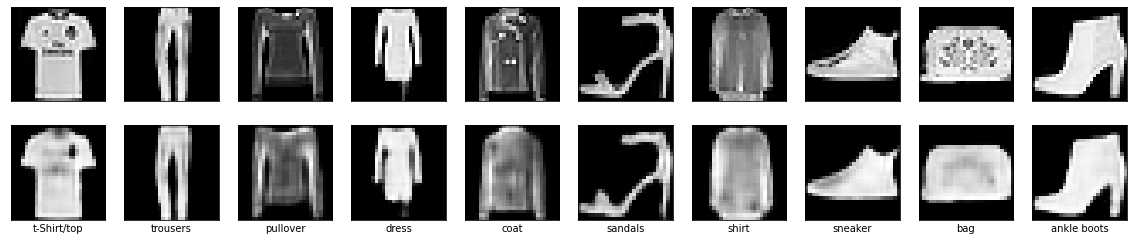

In [16]:
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(original_imgs_classified[i,0])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_classified[i,0])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(labels_name[i])
plt.savefig('images/fmnist_ae/fmnist_reconstructed_all.png', dpi=120)
plt.show()

### 1 class

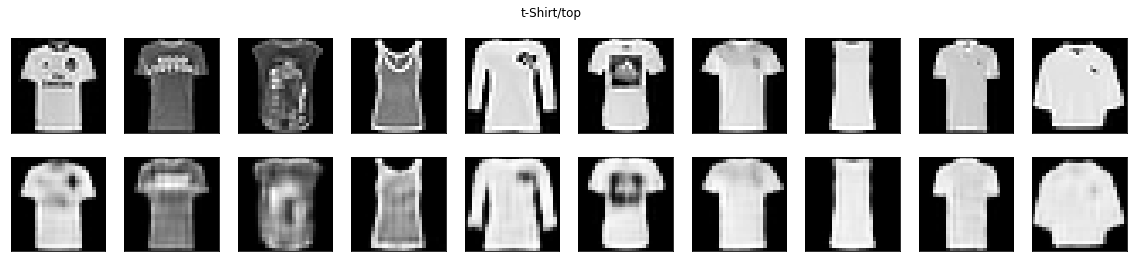

In [43]:
n = 10  # how many images we will display
fig = plt.figure(figsize=(20, 4))
selected_class = 0 # the class to be shown
for i in range(n):
    # display original
    ax = fig.add_subplot(2, n, i + 1)
    plt.imshow(original_imgs_classified[selected_class,i])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

    # display reconstruction
    ax = fig.add_subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_classified[selected_class,i])
    plt.gray()
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(labels_name[selected_class])
plt.savefig('images/fmnist_ae/fmnist_reconstructed_'+str(selected_class)+'.png', dpi=120)
plt.show()

### loss for each class

In [17]:
bce = tf.keras.losses.BinaryCrossentropy();
mse = tf.keras.losses.MeanSquaredError();
loss_test = np.zeros(10)
input_entropy = np.zeros(10)
for i in range(10):
    loss_test[i] = bce(original_imgs_classified[i].reshape(-1,28*28),
        decoded_imgs_classified[i].reshape(-1,28*28)).numpy()
    input_entropy[i] = bce(original_imgs_classified[i].reshape(-1,28*28),
        original_imgs_classified[i].reshape(-1,28*28)).numpy()

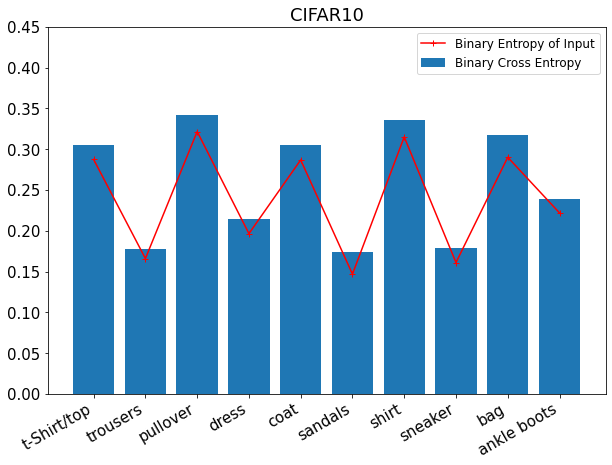

In [18]:
fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(111)

bce_bar = ax.bar(range(10),loss_test)
e_line, = ax.plot(range(10),input_entropy, 'r+-')
ax.set_xticks(range(10))
ax.set_xticklabels(labels_name.values())

#ax.set_ylabel(ylabel='Binary Cross Entropy', fontsize=15)
ax.set_ylim((0,.45))

bce_bar.set_label('Binary Cross Entropy')
e_line.set_label('Binary Entropy of Input')
ax.legend(loc='upper right',
    fontsize='large')

ax.tick_params(labelsize=15)
ax.set_title('CIFAR10', fontsize=18)

fig.autofmt_xdate()

plt.savefig('images/fmnist_ae/fmnist_ae_bce.png',dpi=120)
plt.show()

## t-SNE visualization

In [ ]:
from sklearn.manifold import TSNE

latent_manifold = TSNE(n_components=3, random_state=33)
latent_points = latent_manifold.fit_transform(encoded_imgs) 

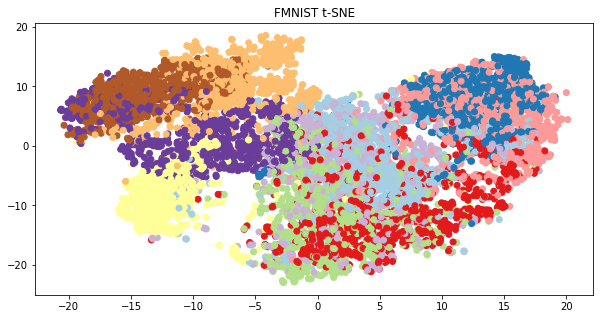

In [20]:
plt.figure(figsize=(10, 5))
plt.scatter(latent_points[:, 0], 
    latent_points[:, 1], 
    #s=10,
    c=labels_test, 
    cmap='Paired',
    label="t-SNE")
plt.savefig('images/fmnist_ae/fmnist_tsne.png', dpi=120)
plt.title('FMNIST t-SNE')
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(labels_name)
plt.show()

## KMeans Clustering

In [ ]:
import sklearn.cluster as cluster

In [ ]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(encoded_imgs)
plt.figure(figsize=(10, 5))
plt.scatter(mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1], 
    c=kmeans_labels, 
    cmap='Paired',
    label="UMAP")
plt.savefig('images/cifar10_ae/cifar10_umap.png', dpi=120)
plt.title('CIFAR10 UMAP with K-Means clustering')
plt.show()

## UMAP visualization

In [22]:
import umap
import umap.plot

In [23]:
mapper = umap.UMAP().fit(encoded_imgs)

<AxesSubplot:>

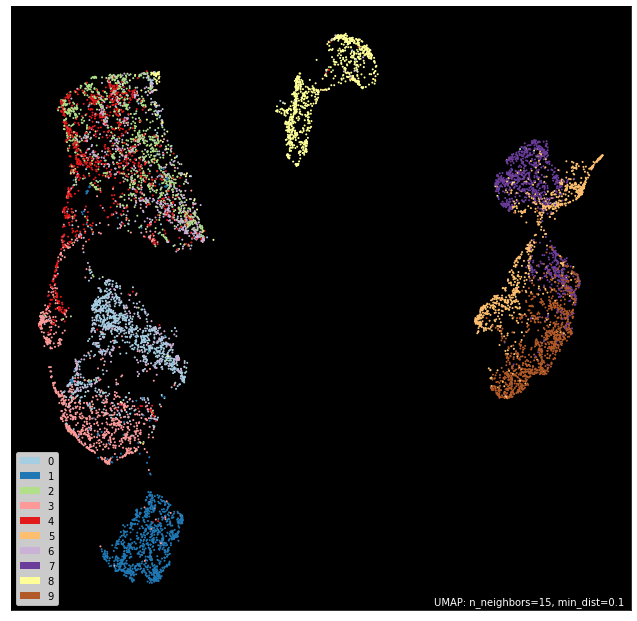

In [24]:
umap.plot.points(mapper, labels=labels_test, color_key_cmap='Paired', background='black')

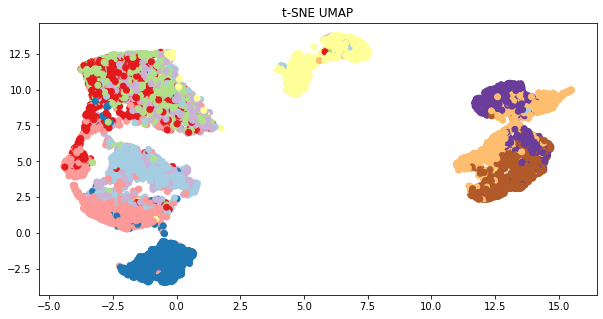

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter(mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1], 
    c=labels_test, 
    cmap='Paired',
    label="t-SNE")
plt.savefig('images/fmnist_ae/fmnist_umap.png', dpi=120)
plt.title('t-SNE UMAP')
plt.show()

## KMeans clustering

In [26]:
import sklearn.cluster as cluster

In [27]:
kmeans_labels = cluster.KMeans(n_clusters=10).fit_predict(encoded_imgs)

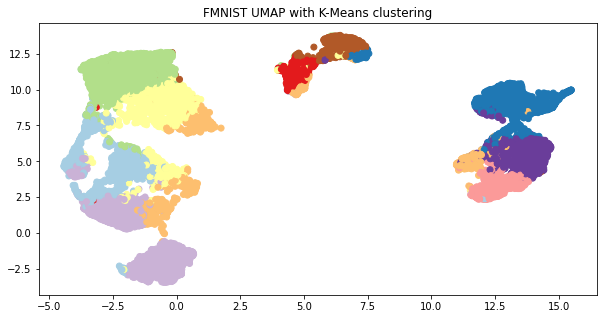

In [28]:
plt.figure(figsize=(10, 5))
plt.scatter(mapper.embedding_[:, 0], 
    mapper.embedding_[:, 1], 
    c=kmeans_labels, 
    cmap='Paired',
    label="UMAP")
plt.savefig('images/cifar10_ae/cifar10_umap.png', dpi=120)
plt.title('FMNIST UMAP with K-Means clustering')
plt.show()